[*********************100%***********************]  2 of 2 completed


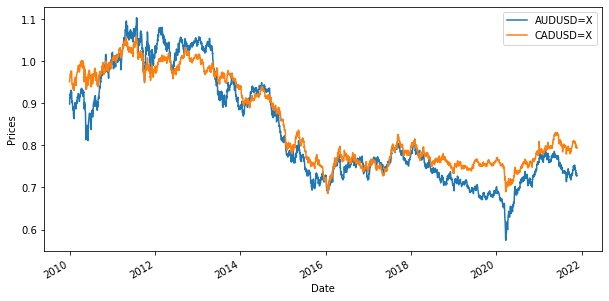

The series is NOT stationary
p-value =  0.06220315872749362


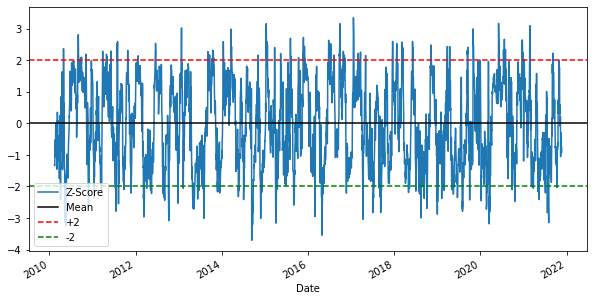

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


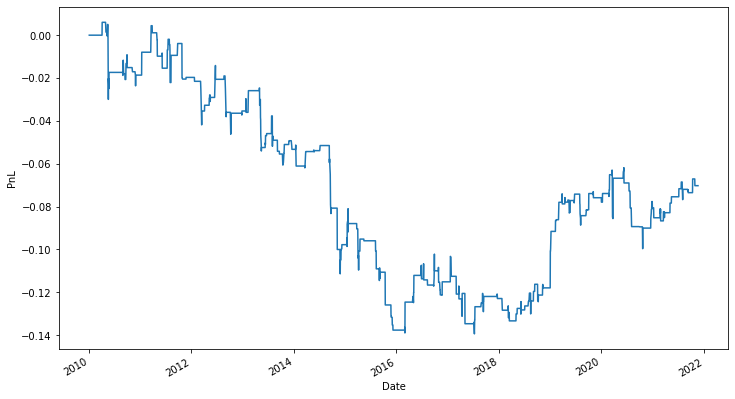

            AUDUSD=X  CADUSD=X     ratio   mavg_30    std_30  positions
Date                                                                   
2010-01-01  0.898473  0.951294  0.944474       NaN       NaN          0
2010-01-04  0.912492  0.960615  0.949904       NaN       NaN          0
2010-01-05  0.911826  0.962001  0.947844       NaN       NaN          0
2010-01-06  0.920471  0.969086  0.949834       NaN       NaN          0
2010-01-07  0.917768  0.967118  0.948972       NaN       NaN          0
...              ...       ...       ...       ...       ...        ...
2021-11-15  0.733251  0.797111  0.919885  0.921474  0.005303          0
2021-11-16  0.734490  0.799105  0.919141  0.921520  0.005275          0
2021-11-17  0.730161  0.795817  0.917499  0.921524  0.005272          0
2021-11-18  0.726860  0.792946  0.916658  0.921531  0.005265          0
2021-11-19  0.727900  0.793430  0.917409  0.921510  0.005281          0

[3095 rows x 6 columns]


In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Import price data from Yahoo Finance
pairs = ['AUDUSD=X', 'CADUSD=X']
data = yf.download(pairs, '2010-01-01')['Close'].dropna()
data.index = pd.to_datetime(data.index)
data.plot(figsize=(10,5))
plt.ylabel('Prices')
plt.xlabel('Date')
plt.show()

# Calculate ratio
ratio = data['AUDUSD=X'] / data['CADUSD=X']
ratio_1 =data['CADUSD=X'] / data['AUDUSD=X']

# Check for cointegration
def stationarity(data, cutoff=0.05):
    if adfuller(data)[1] < cutoff:
        print('The series is stationary')
        print('p-value = ', adfuller(data)[1])
    else:
        print('The series is NOT stationary')
        print('p-value = ', adfuller(data)[1])

stationarity(ratio)

data['ratio'] = data['AUDUSD=X'] / data['CADUSD=X']

# Compute rolling mean of ratio
data['mavg_30'] = data.ratio.rolling(window=30).mean()

# Compute rolling standard deviation of ratio
data['std_30'] = data.ratio.rolling(window=30).std()

# Calculate z-score
z_score = (data.ratio - data.mavg_30)/data.std_30

# Plot z-score
plt.figure(figsize=(10, 5))
z_score.plot()
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Z-Score', 'Mean', '+2', '-2'])
plt.show()

# Define threshold
threshold = 2

# Long entry
long_positions = np.where(z_score < -threshold,1,0)

# Long exit
long_positions = np.where(z_score >= 0, 0, long_positions)
# Short entry
short_positions = np.where(z_score >threshold,1,0)
# Short exit
short_positions = np.where(z_score <= 0, 0, short_positions)

# Combine the positions
data['positions'] = long_positions + short_positions

# Fill NaN values
data = data.fillna(method='ffill')

# Calculate returns
returns = ratio - ratio.shift(1)

# Calculate strategy returns
strategy_returns  = data.positions.shift(1) * returns

# Calculate pnl
pnl = strategy_returns.cumsum()

# Plot the strategy returns
pnl.plot(figsize=(12,7))
plt.xlabel('Date')
plt.ylabel('PnL')
plt.show()

print(data)